In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


In [108]:
class Model(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.GELU(),
            nn.Linear(100, z_dim),
            nn.GELU()
        )

        self.decode = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.GELU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
class CNN(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.encode = nn.Sequential(
            # Convolve
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            # Reshape
            nn.Flatten(1),
            # Linear
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim)
        )
        
        self.decode = nn.Sequential(
            # Linear
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            # Reshape
            nn.Unflatten(1, (32, 3, 3)),
            # Convolve
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [109]:
cnn = CNN(10)
x, _ = next(iter(trainloader))
print(x.shape)
print(cnn.encode(x)[0].shape)
print(cnn(x).shape)

torch.Size([64, 1, 28, 28])
torch.Size([10])
torch.Size([64, 1, 28, 28])


In [110]:
z_dim = 10
model = CNN(z_dim).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

n_epochs = 50
losses = []
for epoch in tqdm(range(1, n_epochs+1)):
    batch_losses = []
    for x, _ in trainloader:
        x = x.to(device)
        x_hat = model(x)
        
        loss = loss_fn(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
    

100%|██████████| 50/50 [06:25<00:00,  7.71s/it]


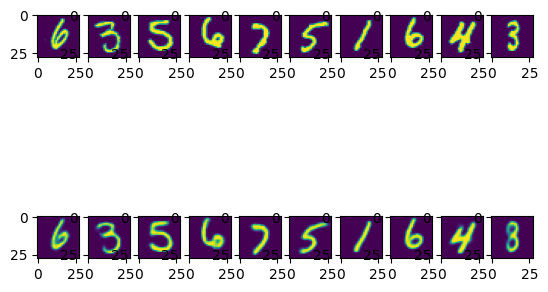

In [53]:
for x, _ in valloader:
    fig, ax = plt.subplots(2, z_dim)
    x = x.to(device)
    x_hat = model(x).cpu().detach().numpy()

    for n in range(10):
        ax[0][n].imshow(x[n][0].cpu())
        ax[1][n].imshow(x_hat[n][0])

    break

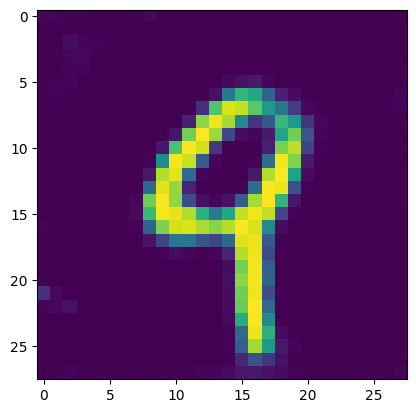

In [84]:
z = torch.randn(1,10).to(device)

plt.imshow(model.decode(z).cpu().detach().numpy()[0][0])